![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <center>Richter's Predictor: Modeling Earthquake Damage</center>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
from random import randint
from IPython.display import clear_output
from collections import Counter

from sklearn.model_selection import  train_test_split, StratifiedKFold,GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import  StandardScaler, LabelBinarizer
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from lazypredict.Supervised import LazyClassifier

## DATASET

In [2]:
# Lee los archivos CSV
train_values = pd.read_csv('https://raw.githubusercontent.com/Nestorbd/Richter-s-Predictor-Modeling-Earthquake-Damage/master/datasets/train_values.csv')
train_labels = pd.read_csv('https://raw.githubusercontent.com/Nestorbd/Richter-s-Predictor-Modeling-Earthquake-Damage/master/datasets/train_labels.csv')

# Combina los dos DataFrames usando merge
df = pd.merge(train_values, train_labels, how='outer', on=['building_id'])

# Guarda el DataFrame combinado en un nuevo archivo CSV
df.to_csv('earthquake_train.csv', index=False)
df.shape

(260601, 40)

In [3]:
df['land_surface_condition'].replace(['n', 'o', 't'],[0, 1, 2], inplace=True)
df['foundation_type'].replace(['h', 'i', 'r', 'u', 'w'],[0, 1, 2, 3, 4], inplace=True)
df['roof_type'].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
df['ground_floor_type'].replace(['f', 'm', 'v', 'x', 'z'],[0, 1, 2, 3, 4], inplace=True)
df['other_floor_type'].replace(['j', 'q', 's', 'x'],[0, 1, 2, 3], inplace=True)
df['position'].replace(['j', 'o', 's', 't'],[0, 1, 2, 3], inplace=True)
df['plan_configuration'].replace(['a', 'c', 'd', 'f', 'm','n', 'o', 'q', 's','u'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
df['legal_ownership_status'].replace(['a', 'r', 'v', 'w'],[0, 1, 2, 3], inplace=True)

## OVERVIEW

In [4]:
df.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,...,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00
mean,525675.48,13.90,701.07,6257.88,2.13,26.54,8.02,5.43,1.70,2.12,...,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,2.24
std,304545.00,8.03,412.71,3646.37,0.73,73.57,4.39,1.92,0.70,0.58,...,0.18,0.09,0.03,0.02,0.03,0.01,0.01,0.01,0.07,0.61
min,4.00,0.00,0.00,0.00,1.00,0.00,1.00,2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,261190.00,7.00,350.00,3073.00,2.00,10.00,5.00,4.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,525757.00,12.00,702.00,6270.00,2.00,15.00,7.00,5.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
75%,789762.00,21.00,1050.00,9412.00,2.00,30.00,9.00,6.00,2.00,2.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
max,1052934.00,30.00,1427.00,12567.00,9.00,995.00,100.00,32.00,2.00,4.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,3.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   building_id                             260601 non-null  int64
 1   geo_level_1_id                          260601 non-null  int64
 2   geo_level_2_id                          260601 non-null  int64
 3   geo_level_3_id                          260601 non-null  int64
 4   count_floors_pre_eq                     260601 non-null  int64
 5   age                                     260601 non-null  int64
 6   area_percentage                         260601 non-null  int64
 7   height_percentage                       260601 non-null  int64
 8   land_surface_condition                  260601 non-null  int64
 9   foundation_type                         260601 non-null  int64
 10  roof_type                               260601 non-null  int64
 11  

In [6]:
df.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

## ANÁLISIS

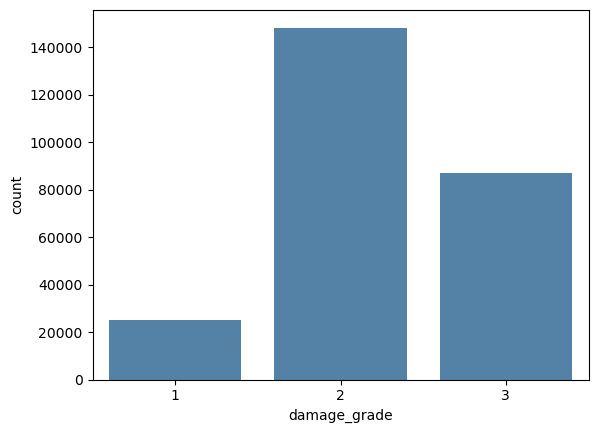

In [7]:
sns.countplot(data = df, x = 'damage_grade', fill = True, color = 'steelblue');

## PROCESAMIENTO DE DATOS

### NORMALIZACIÓN

In [32]:
column_names = df.columns.values
index_to_remove = np.where(column_names == 'damage_grade')[0]
column_names = np.delete(column_names, index_to_remove)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop('damage_grade', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

df_scaled = scaled_df.copy()
df_scaled["damage_grade"] = df["damage_grade"]

In [9]:
df_scaled.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,0.91,-0.98,-0.52,1.63,-0.18,0.05,-0.46,-0.23,0.44,-0.21,...,-0.19,-0.09,-0.03,-0.02,-0.03,-0.01,-0.01,-0.01,-0.07,3
1,-1.63,-0.73,0.48,-0.95,-0.18,-0.22,-0.00,0.82,-1.00,-0.21,...,-0.19,-0.09,-0.03,-0.02,-0.03,-0.01,-0.01,-0.01,-0.07,2
2,-1.41,0.88,-0.82,0.74,-0.18,-0.22,-0.69,-0.23,0.44,-0.21,...,-0.19,-0.09,-0.03,-0.02,-0.03,-0.01,-0.01,-0.01,-0.07,3
3,0.21,1.01,-0.69,1.22,-0.18,-0.22,-0.46,-0.23,0.44,-0.21,...,-0.19,-0.09,-0.03,-0.02,-0.03,-0.01,-0.01,-0.01,-0.07,2
4,-1.06,-0.36,-1.38,-1.31,1.20,0.05,-0.00,1.86,0.44,-0.21,...,-0.19,-0.09,-0.03,-0.02,-0.03,-0.01,-0.01,-0.01,-0.07,3


### DIVIDIR LOS DATOS

In [10]:
X = df_scaled.drop('damage_grade', axis=1)
y = df_scaled['damage_grade']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

## SELECCIÓN DE CARACTERÍSTICAS

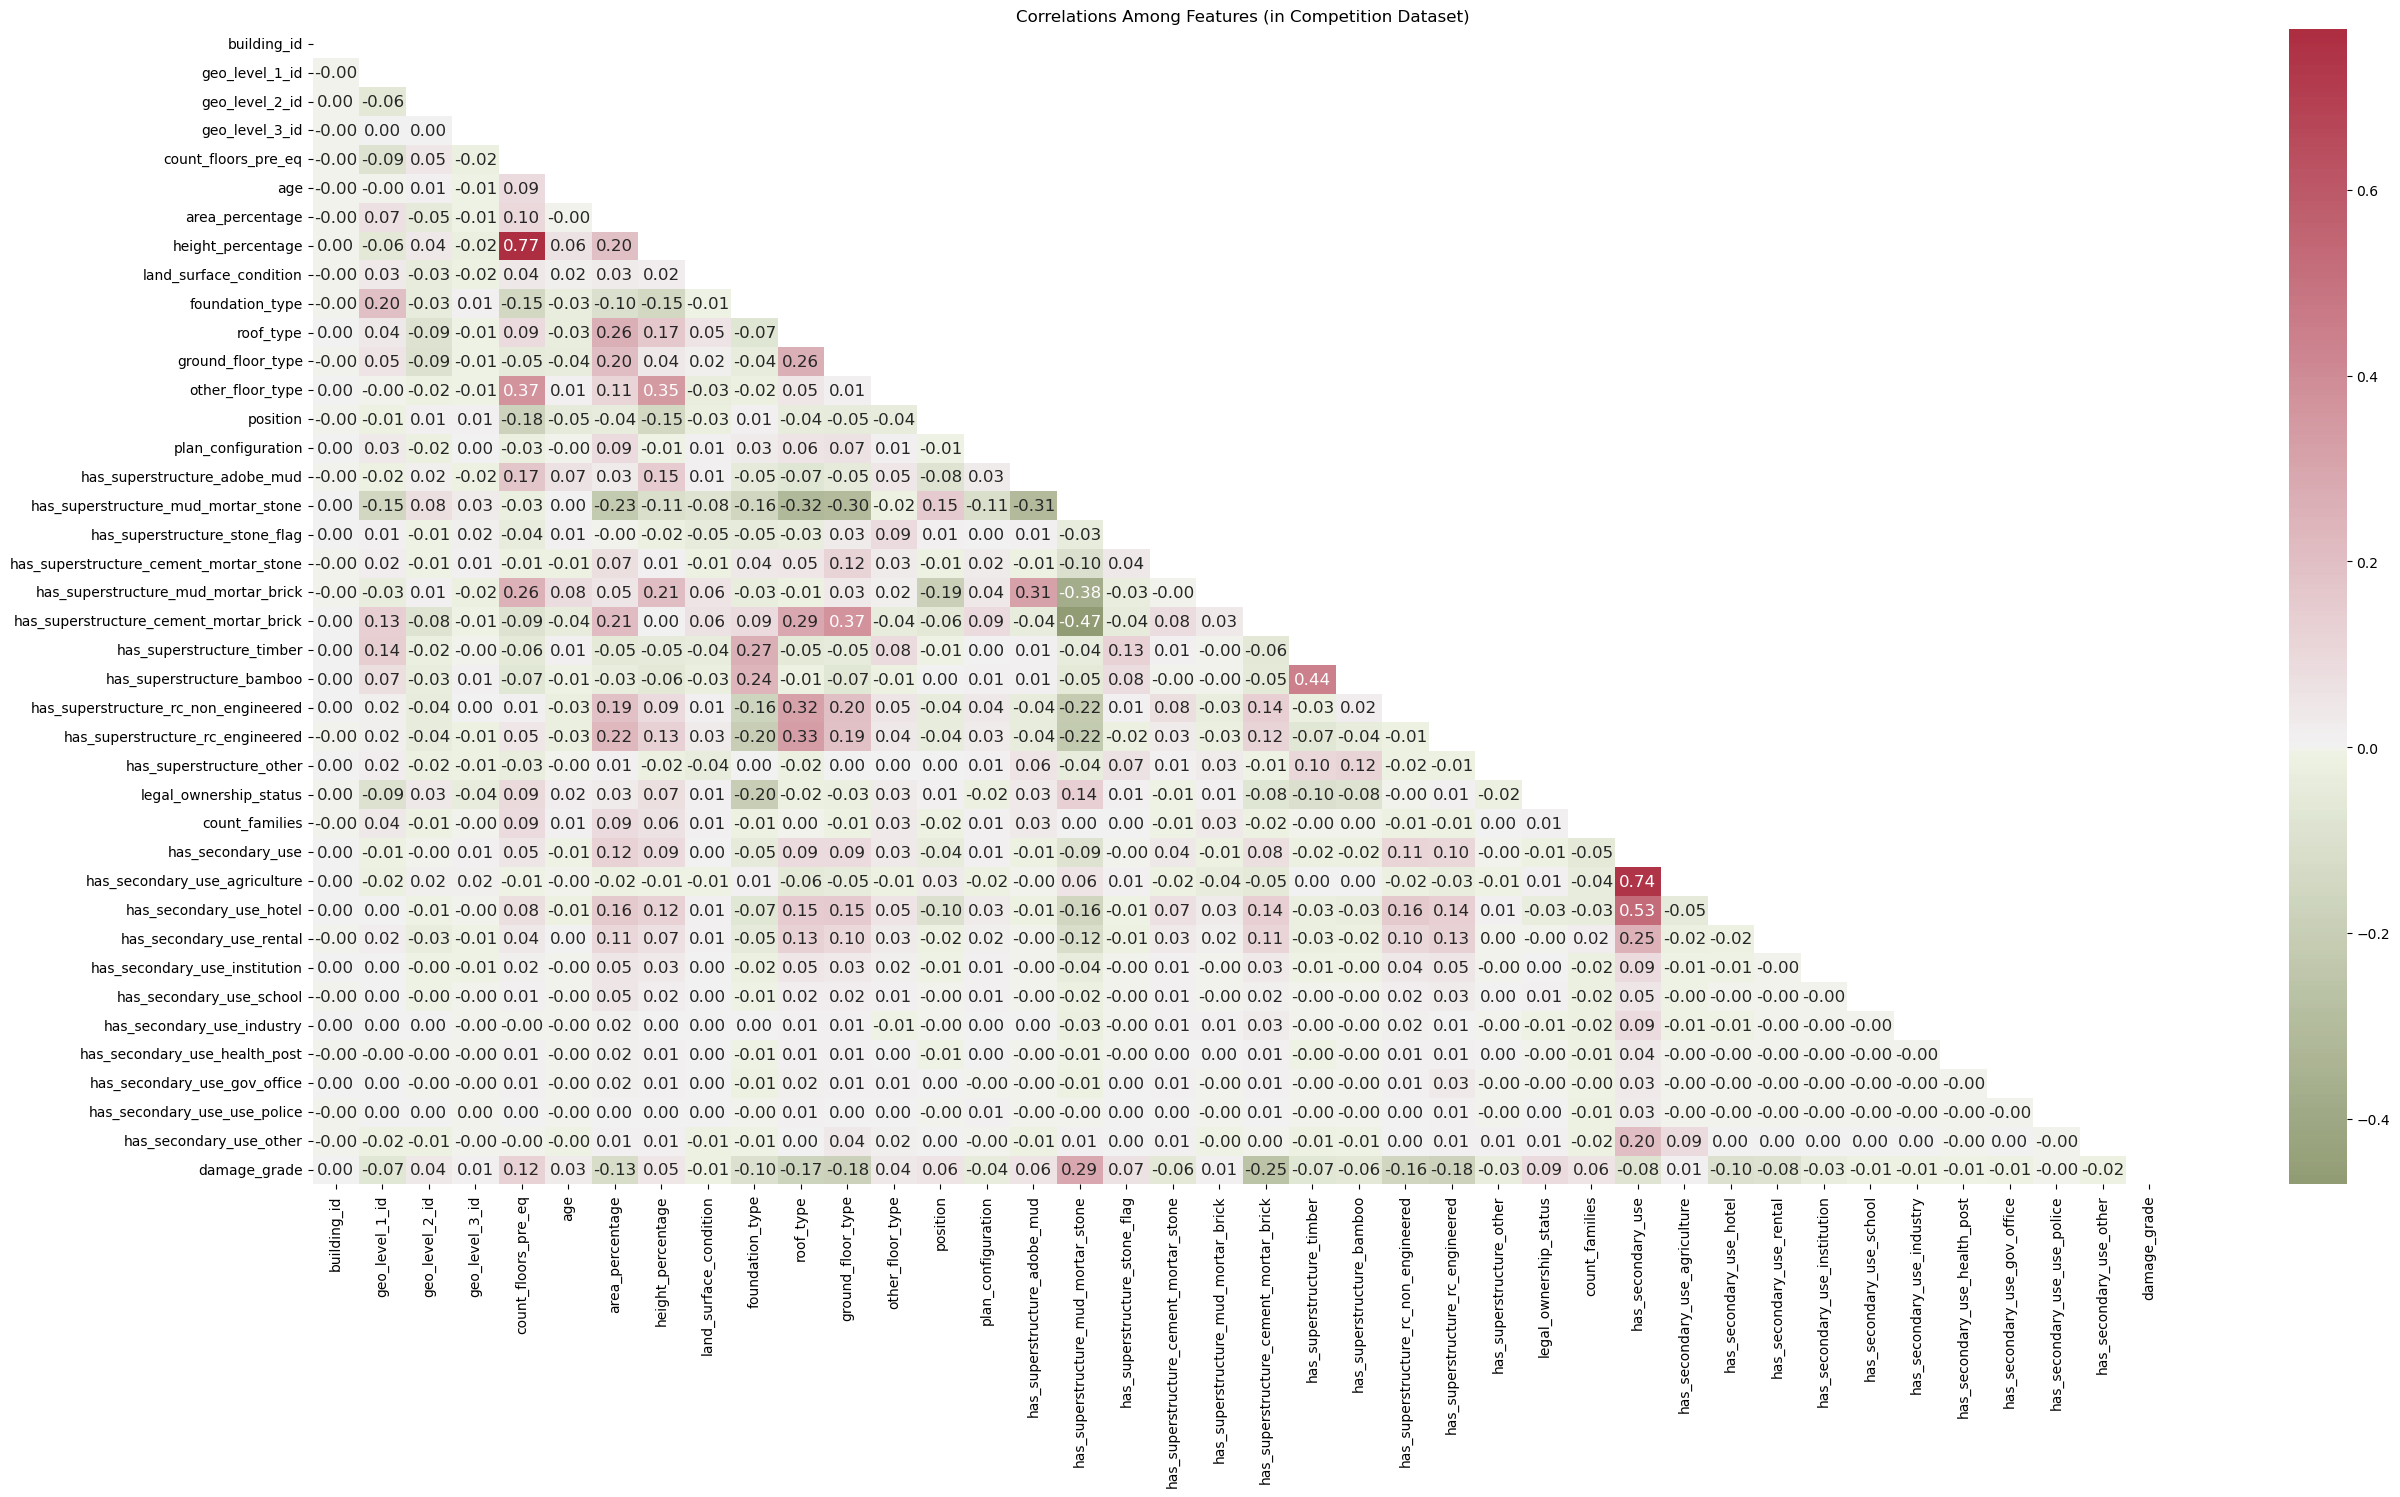

In [11]:
# Calcular la matriz de correlación
corr_mat_data = df_scaled.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (30, 15))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)');

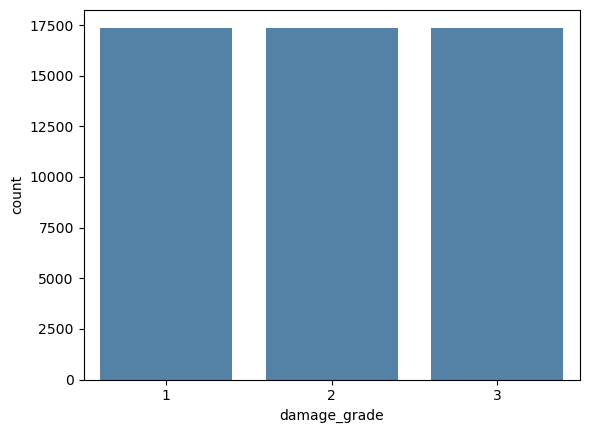

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

subconjuntos = [df_scaled[df_scaled['damage_grade'] == categoria] for categoria in df_scaled['damage_grade'].unique()]

# Determina el tamaño de la muestra deseada (puede ser el mismo para todas las categorías o diferente)
tamano_muestra = int(len(df_scaled) * 0.2)

# Selecciona una muestra aleatoria de cada subconjunto
muestras_balanceadas = [subconjunto.sample(n=tamano_muestra//len(subconjuntos)) for subconjunto in subconjuntos]

# Combina las muestras balanceadas en un único DataFrame
muestra_balanceada = pd.concat(muestras_balanceadas)

sns.countplot(data = muestra_balanceada, x = 'damage_grade', fill = True, color = 'steelblue');

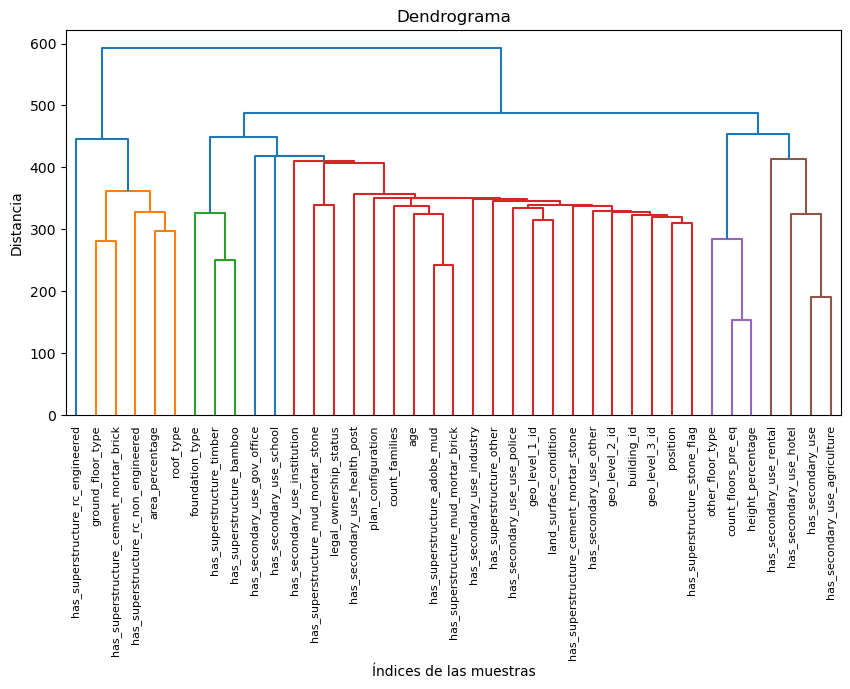

In [13]:
X_muestra = muestra_balanceada.drop('damage_grade', axis=1)
y_muestra = muestra_balanceada['damage_grade']

# Calcular la matriz de distancias
Z = linkage(X_muestra.T, 'ward')

# Crear el dendrograma
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=X_muestra.columns.to_list(), leaf_rotation=90)

plt.title('Dendrograma')
plt.xlabel('Índices de las muestras')
plt.ylabel('Distancia')
plt.show()

In [14]:
from scipy.cluster.hierarchy import fcluster

# Obtener los clusters a partir del dendrograma
k = 8  # Número de clusters deseado
clusters = fcluster(Z, k, criterion='maxclust')

# Crear una lista de listas para almacenar las características de cada cluster
cluster_features = [[] for _ in range(k)]

# Asignar características a cada cluster
for idx, cluster_num in enumerate(clusters):
    # Asignar la característica correspondiente al índice idx al cluster cluster_num
    cluster_features[cluster_num - 1].append(X_muestra.columns[idx])

# Imprimir las características de cada cluster
for i, features in enumerate(cluster_features):
    print(f"Cluster {i+1}: {features}")

Cluster 1: ['area_percentage', 'roof_type', 'ground_floor_type', 'has_superstructure_cement_mortar_brick', 'has_superstructure_rc_non_engineered']
Cluster 2: ['has_superstructure_rc_engineered']
Cluster 3: ['foundation_type', 'has_superstructure_timber', 'has_superstructure_bamboo']
Cluster 4: ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'age', 'land_surface_condition', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_other', 'legal_ownership_status', 'count_families', 'has_secondary_use_institution', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_use_police', 'has_secondary_use_other']
Cluster 5: ['has_secondary_use_school']
Cluster 6: ['has_secondary_use_gov_office']
Cluster 7: ['count_floors_pre_eq', 'height_percentage', 'other_floor_typ

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif

# Crear un objeto SelectKBest para cada cluster
select_k_best_list = []
selected_features = []

for cluster in cluster_features:
    # Obtener índices de las características del cluster en el DataFrame original
    feature_indices = [muestra_balanceada.columns.get_loc(feature) for feature in cluster]

    K = 1
    if(len(feature_indices) > 5):
        K=3

    # Seleccionar las k mejores características para el cluster actual
    select_k_best = SelectKBest(score_func=f_classif, k=K)  # Seleccionar 2 características por cluster
    select_k_best.fit(muestra_balanceada.iloc[:, feature_indices], y_muestra)  # Ajustar SelectKBest con las características del cluster
    
    # Guardar el objeto SelectKBest en la lista
    select_k_best_list.append(select_k_best)

    # Obtener la máscara de booleanos de las características seleccionadas
    mask = select_k_best.get_support()

    # Obtener los nombres de las características seleccionadas
    features = [cluster[i] for i, selected in enumerate(mask) if selected]

    selected_features.append(features)

# Imprimir las características seleccionadas por cada cluster
for i, features in enumerate(selected_features):
    print(f"Cluster {i+1} - Características seleccionadas: {features}")

Cluster 1 - Características seleccionadas: ['has_superstructure_cement_mortar_brick']
Cluster 2 - Características seleccionadas: ['has_superstructure_rc_engineered']
Cluster 3 - Características seleccionadas: ['foundation_type']
Cluster 4 - Características seleccionadas: ['geo_level_1_id', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone']
Cluster 5 - Características seleccionadas: ['has_secondary_use_school']
Cluster 6 - Características seleccionadas: ['has_secondary_use_gov_office']
Cluster 7 - Características seleccionadas: ['count_floors_pre_eq']
Cluster 8 - Características seleccionadas: ['has_secondary_use_hotel']


In [16]:
# Unir todas las características seleccionadas en un solo array
all_selected_features = np.concatenate(selected_features)

# Imprimir el array con todas las características seleccionadas
print("Todas las características seleccionadas:")
print(all_selected_features)

Todas las características seleccionadas:
['has_superstructure_cement_mortar_brick'
 'has_superstructure_rc_engineered' 'foundation_type' 'geo_level_1_id'
 'has_superstructure_adobe_mud' 'has_superstructure_mud_mortar_stone'
 'has_secondary_use_school' 'has_secondary_use_gov_office'
 'count_floors_pre_eq' 'has_secondary_use_hotel']


In [17]:
X_train = X_train[all_selected_features]
X_val = X_val[all_selected_features]
X_test = X_test[all_selected_features]

## SELECCIONAR ESTRATEGIA

In [19]:
def display_roc_curve(y_onehot_val, y_pred_prob, n_elements):
    # Calcular la Curva ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_elements = 3


    for i in range(n_elements):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_val[:,i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficar la Curva ROC para cada clase
    plt.figure()
    for i in range(n_elements):
        plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
    plt.legend(loc="lower right")
    plt.show()

In [20]:
def display_pr_curve(y_onehot_val, y_pred_prob, n_elements):
     # Calcular la Curva PR para cada clase
    precision = dict()
    recall = dict()
    for i in range(n_elements):
        precision[i], recall[i], _ = precision_recall_curve(y_onehot_val[:, i], y_pred_prob[:, i])

    # Graficar la Curva PR para cada clase
    plt.figure()
    for i in range(n_elements):
        plt.plot(recall[i], precision[i], label='PR curve (class {})'.format(i+1))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multiclass')
    plt.legend(loc="lower left")
    plt.show()

In [21]:
LABELS = ["1", "2", "3"]
def mostrar_resultados(model, X_test, y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_val = label_binarizer.transform(y_test)

    # Obtener las probabilidades de predicción del modelo para todas las clases
    y_pred_prob = model.predict_proba(X_test)

    n_elements = len(LABELS)

    display_roc_curve(y_onehot_val, y_pred_prob, n_elements)
    display_pr_curve(y_onehot_val, y_pred_prob, n_elements)

    print (classification_report(y_test, pred_y))

### SIN ESTRATEGIA

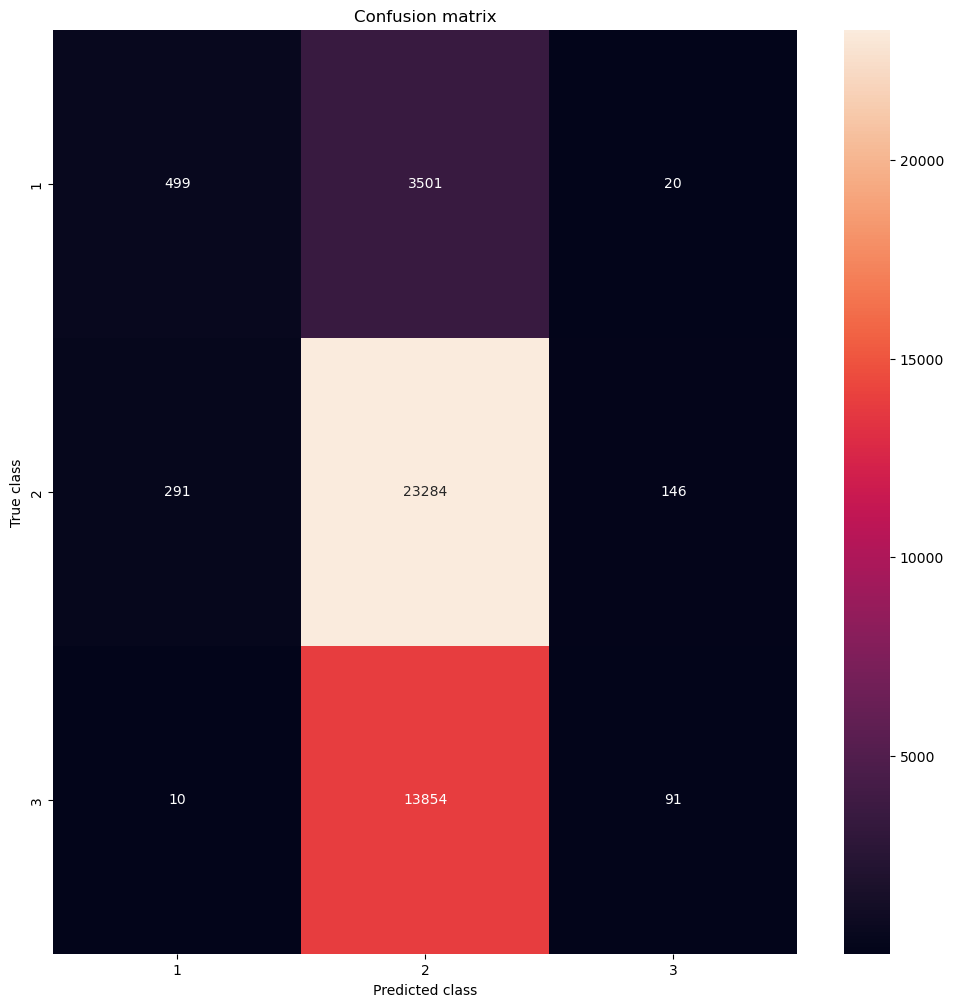

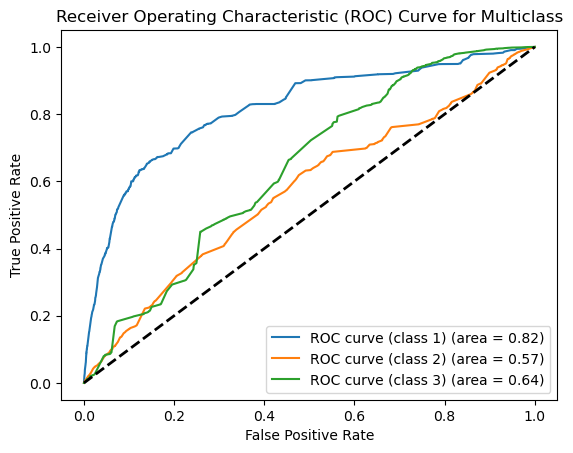

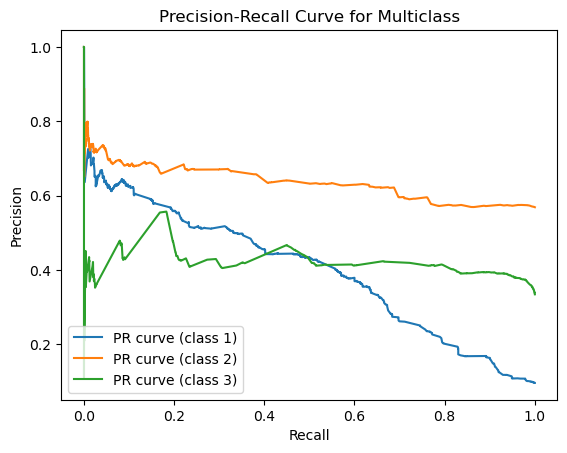

              precision    recall  f1-score   support

           1       0.62      0.12      0.21      4020
           2       0.57      0.98      0.72     23721
           3       0.35      0.01      0.01     13955

    accuracy                           0.57     41696
   macro avg       0.52      0.37      0.31     41696
weighted avg       0.50      0.57      0.44     41696



In [22]:
model = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="liblinear")
model.fit(X_train,y_train)
pred_y = model.predict(X_val)
mostrar_resultados(model, X_val, y_val, pred_y)

### ESTRATEGIA: Penalización

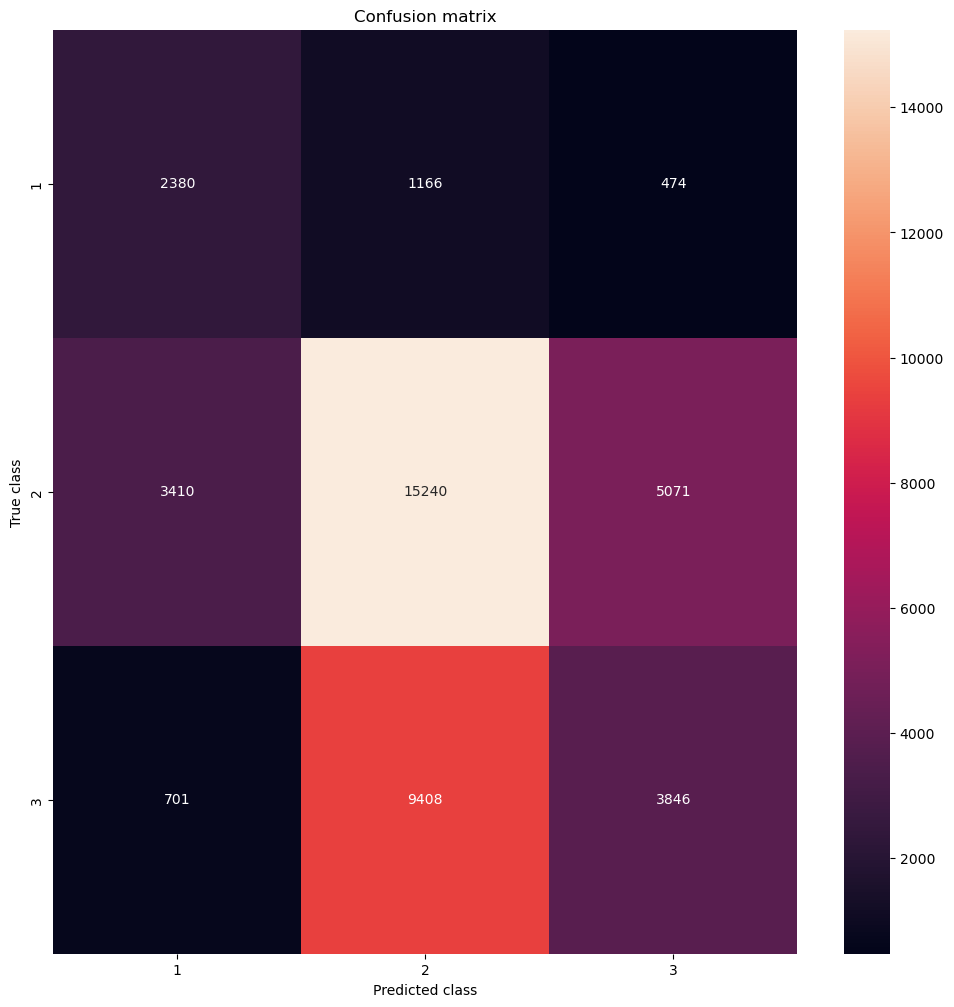

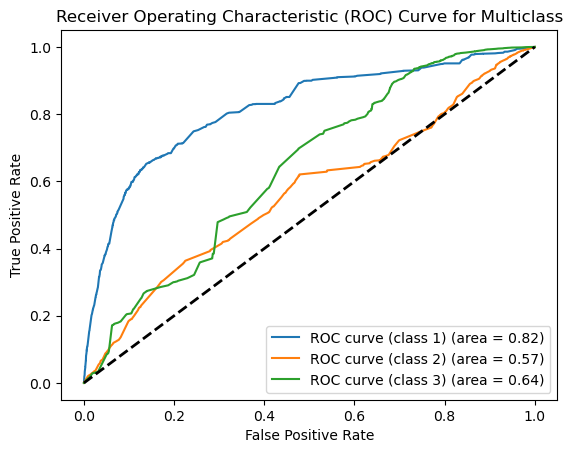

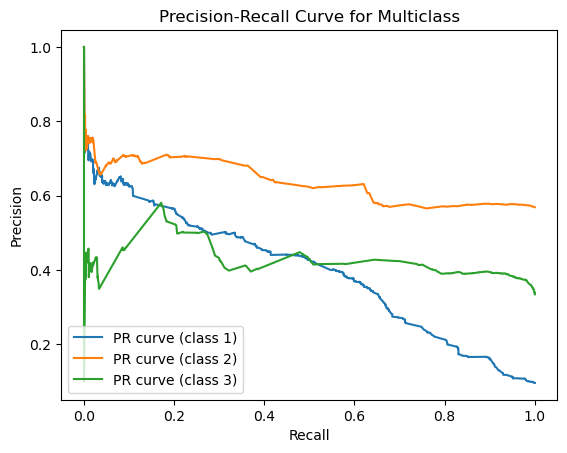

              precision    recall  f1-score   support

           1       0.37      0.59      0.45      4020
           2       0.59      0.64      0.62     23721
           3       0.41      0.28      0.33     13955

    accuracy                           0.51     41696
   macro avg       0.46      0.50      0.47     41696
weighted avg       0.51      0.51      0.50     41696



In [23]:
model = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="liblinear",class_weight="balanced")
model.fit(X_train, y_train)
pred_y = model.predict(X_val)
mostrar_resultados(model, X_val, y_val, pred_y)

### ESTRATEGIA: Subsampling de las clases mayoritarias

In [24]:
def subsampling_strategy(model, X_train, y_train, X_test, y_test):
    us = NearMiss(n_neighbors=3, version=2)
    X_train_res, y_train_res = us.fit_resample(X_train, y_train)

    print ("Distribution before resampling {}".format(Counter(y_train)))
    print ("Distribution after resampling {}".format(Counter(y_train_res)))

    model.fit(X_train_res, y_train_res)
    pred_y = model.predict(X_test)
    mostrar_resultados(model, X_test, y_test, pred_y)

Distribution before resampling Counter({2: 94886, 3: 55819, 1: 16079})
Distribution after resampling Counter({1: 16079, 2: 16079, 3: 16079})


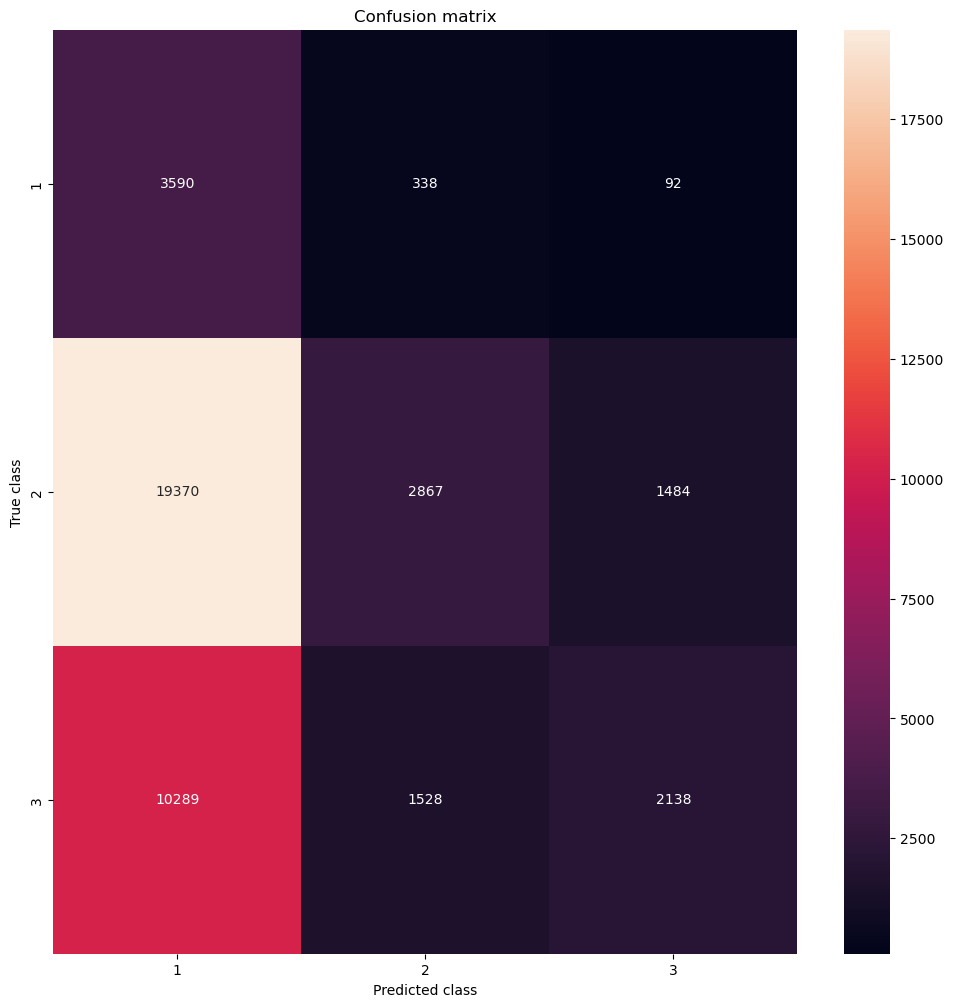

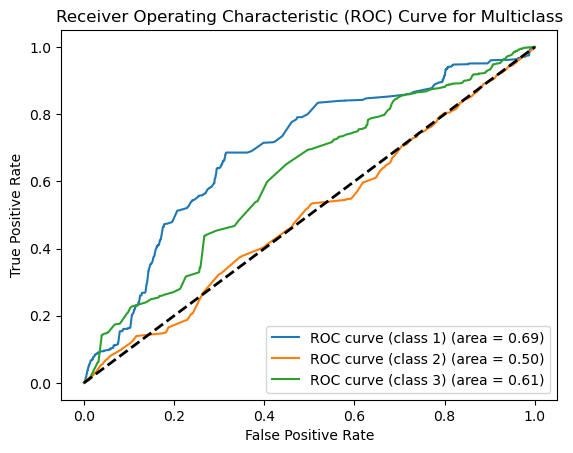

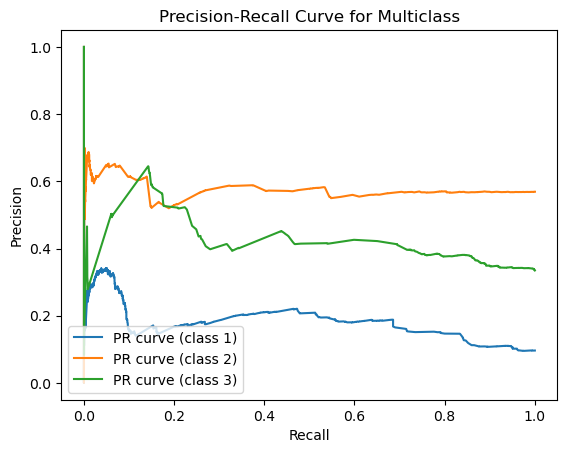

              precision    recall  f1-score   support

           1       0.11      0.89      0.19      4020
           2       0.61      0.12      0.20     23721
           3       0.58      0.15      0.24     13955

    accuracy                           0.21     41696
   macro avg       0.43      0.39      0.21     41696
weighted avg       0.55      0.21      0.21     41696



In [25]:
model = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="liblinear")
subsampling_strategy(model, X_train, y_train, X_val, y_val)

### ESTRATEGIA: Oversampling de la clase minoritaria

In [26]:
def oversampling_strategy(model, X_train, y_train, X_test, y_test):
    os =  RandomOverSampler()
    X_train_res, y_train_res = os.fit_resample(X_train, y_train)
    
    print ("Distribution before resampling {}".format(Counter(y_train)))
    print ("Distribution labels after resampling {}".format(Counter(y_train_res)))
    
    model.fit(X_train_res, y_train_res)
    pred_y = model.predict(X_test)
    mostrar_resultados(model, X_test, y_test, pred_y)

Distribution before resampling Counter({2: 94886, 3: 55819, 1: 16079})
Distribution labels after resampling Counter({3: 94886, 2: 94886, 1: 94886})


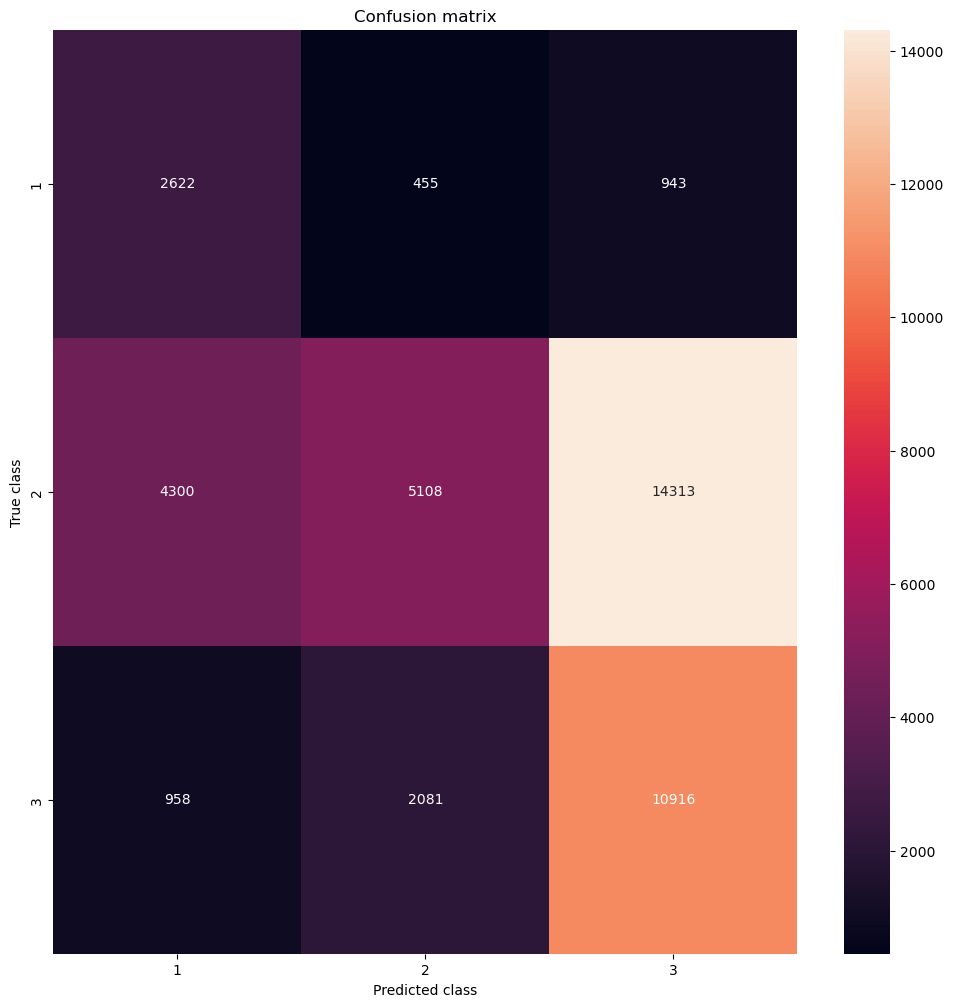

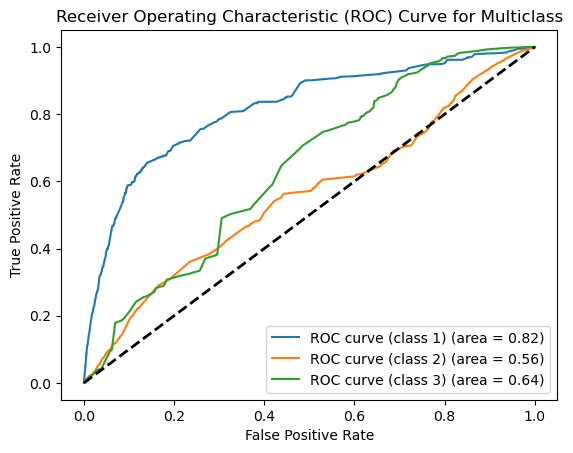

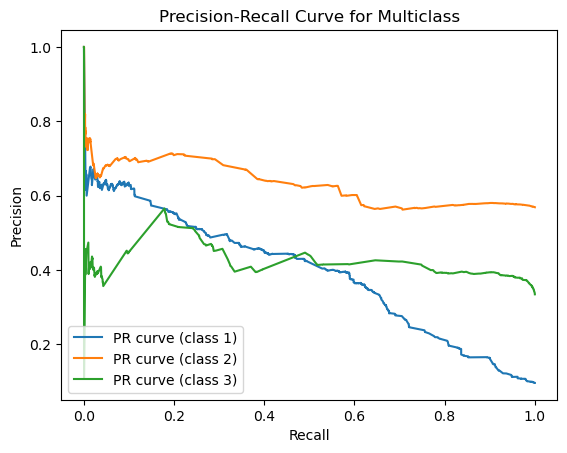

              precision    recall  f1-score   support

           1       0.33      0.65      0.44      4020
           2       0.67      0.22      0.33     23721
           3       0.42      0.78      0.54     13955

    accuracy                           0.45     41696
   macro avg       0.47      0.55      0.44     41696
weighted avg       0.55      0.45      0.41     41696



In [27]:
model = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="liblinear")
oversampling_strategy(model, X_train, y_train, X_val, y_val)

### ESTRATEGIA: Combinamos resampling con Smote-Tomek

In [28]:
def resampling_with_SmoteTomek_strategy(model, X_train, y_train, X_test, y_test):    
    os_us = SMOTETomek()
    X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
    
    print ("Distribution before resampling {}".format(Counter(y_train)))
    print ("Distribution after resampling {}".format(Counter(y_train_res)))
    
    model.fit(X_train_res, y_train_res)
    pred_y = model.predict(X_test)
    mostrar_resultados(model, X_test, y_test, pred_y)

Distribution before resampling Counter({2: 94886, 3: 55819, 1: 16079})
Distribution after resampling Counter({2: 94792, 3: 94737, 1: 94695})


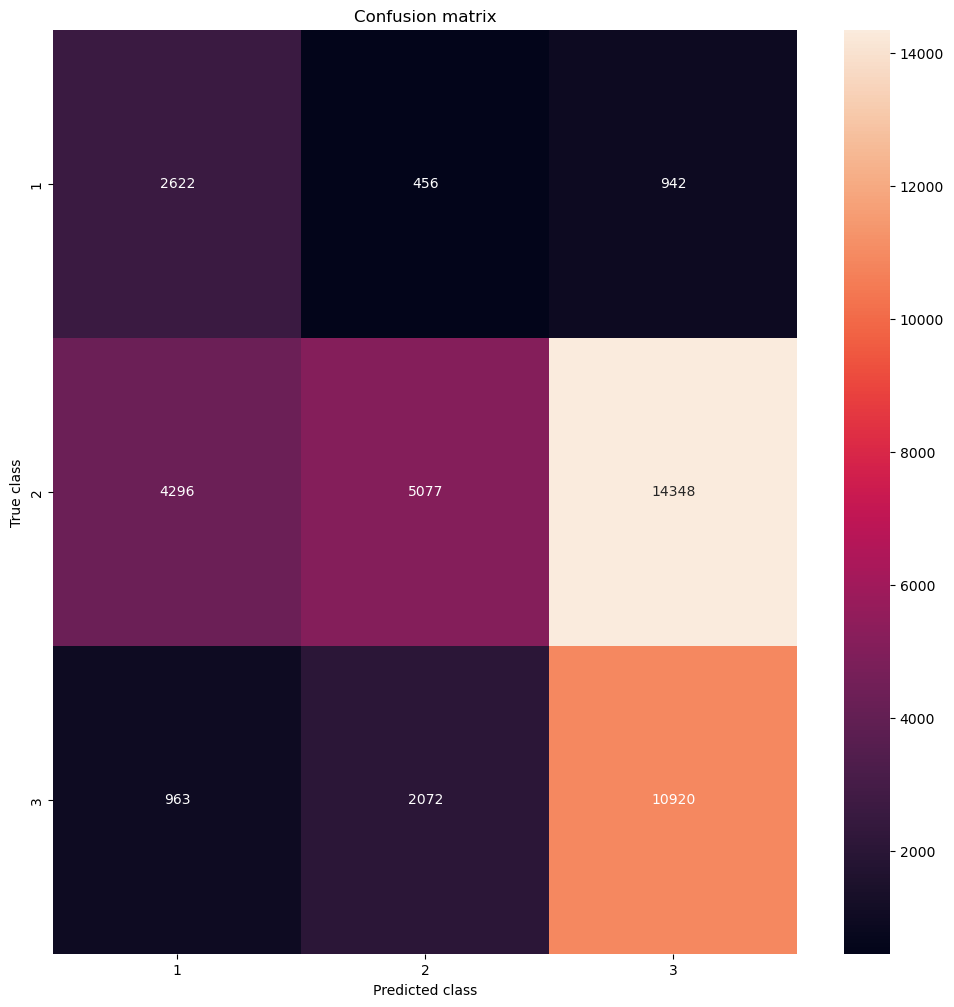

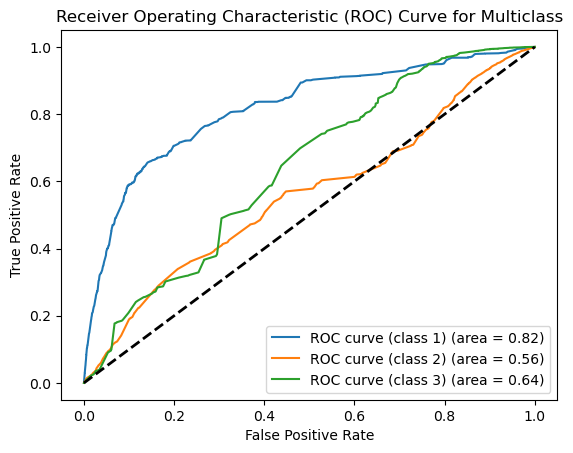

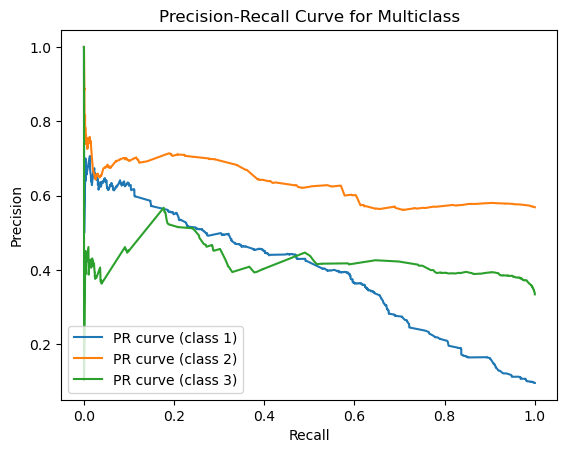

              precision    recall  f1-score   support

           1       0.33      0.65      0.44      4020
           2       0.67      0.21      0.32     23721
           3       0.42      0.78      0.54     13955

    accuracy                           0.45     41696
   macro avg       0.47      0.55      0.44     41696
weighted avg       0.55      0.45      0.41     41696



In [29]:
model = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="liblinear")
resampling_with_SmoteTomek_strategy(model, X_train, y_train, X_val, y_val)

### ESTRATEGIA: Ensamble de Modelos con Balanceo

In [33]:
def balanced_ensable_models_strategy(model, X_train, y_train, X_test, y_test):   
    bbc = BalancedBaggingClassifier(estimator=model,
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=0)
    #Train the classifier.
    bbc.fit(X_train, y_train)
    pred_y = bbc.predict(X_test)
    mostrar_resultados(bbc, X_test, y_test, pred_y)

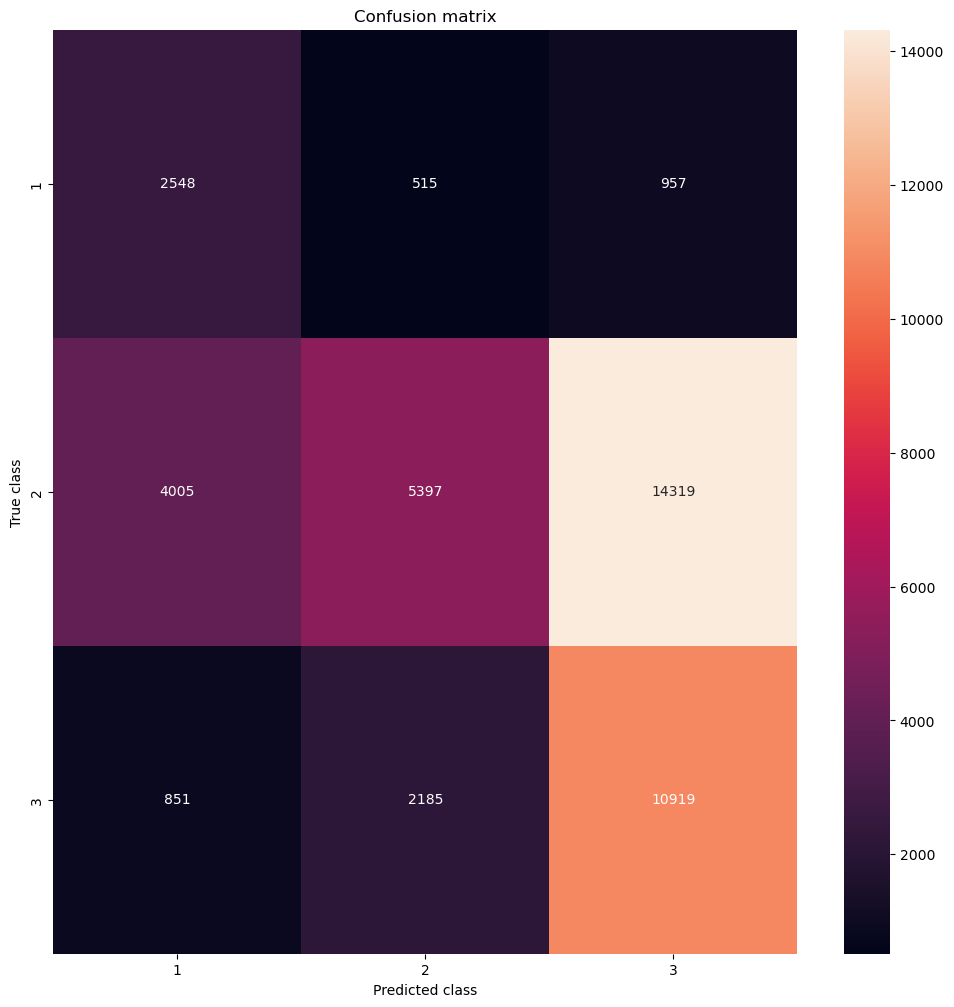

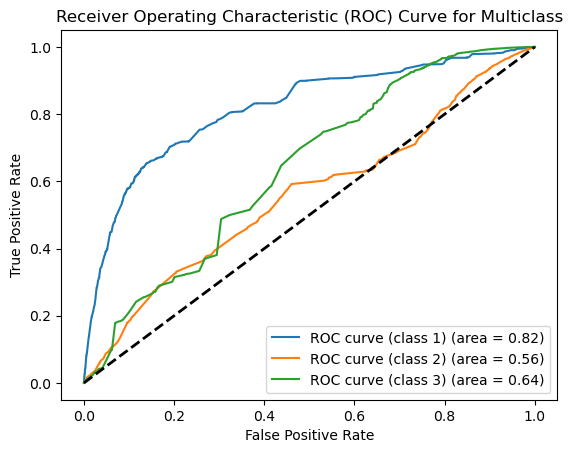

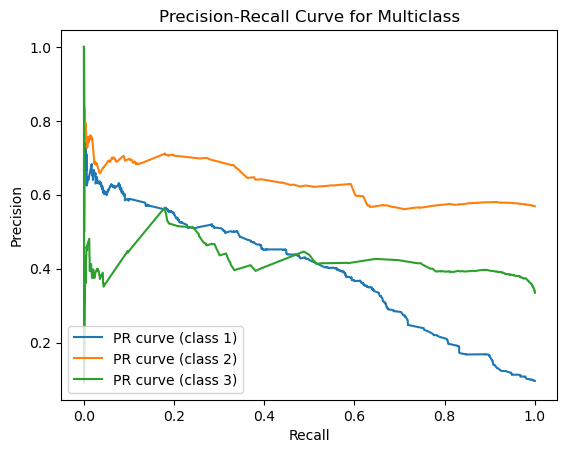

              precision    recall  f1-score   support

           1       0.34      0.63      0.45      4020
           2       0.67      0.23      0.34     23721
           3       0.42      0.78      0.54     13955

    accuracy                           0.45     41696
   macro avg       0.48      0.55      0.44     41696
weighted avg       0.55      0.45      0.42     41696



In [34]:
balanced_ensable_models_strategy(LogisticRegression(), X_train, y_train, X_val, y_val)

## SELECCIONAR UN MODELO

In [ ]:
def best_params(model, params, min_splits=2, max_splits=100, CV_technique = "all"):
    best_split = np.inf
    best_params = {}
    best_score = 0
    technique = "anyone"
    train_model = None
    train_model_anyone = None
    train_model_gs = None
    train_model_rs = None

    scorer = make_scorer(f1_score, average='micro')

    if (CV_technique == "anyone" or CV_technique == "all"):
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        f1_micro = f1_score(y_val, predictions, average='micro')

        if(f1_micro > best_score):
            best_score = f1_micro
            technique = "anyone"
            best_params = {}
            train_model_anyone = model
    if(CV_technique != "anyone"):
        while (max_splits - min_splits) >= 10:
            split = randint(min_splits, max_splits)
            min = split - 5
            max = split + 5

            if(min < min_splits):
                min = min_splits
            if(max > max_splits):
                max = max_splits

            for s in range(min,max):
                clear_output()
                print("min:",min_splits, "max:",max_splits, "actual:", split)
                print("search:", min, "-",max, "actual:",s)
                skf = StratifiedKFold(n_splits=s, shuffle=True, random_state=42)
                if(CV_technique == "gridSearchCV" or CV_technique == "all"):
                    # Inicializar GridSearchCV
                    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=skf, n_jobs=-1, scoring=scorer)

                    # Ajustar el modelo utilizando GridSearchCV
                    grid_search.fit(X_train, y_train)

                    if(grid_search.best_score_ > best_score):

                        # Obtener los mejores hiperparámetros
                        best_params = grid_search.best_params_
                        best_score =  grid_search.best_score_
                        technique = "gridSearchCV"
                        best_split = s
                        train_model_gs = grid_search
                    print("gridSearchCV Finish")

                if(CV_technique == "randomizeSearchCV" or CV_technique == "all"):
                    # Inicializar GridSearchCV
                    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=10, cv=skf, n_jobs=-1, scoring=scorer)
                                # Ajustar el modelo utilizando GridSearchCV
                    random_search.fit(X_train, y_train)

                    if(random_search.best_score_ > best_score):

                        # Obtener los mejores hiperparámetros
                        best_params = random_search.best_params_
                        best_score =  random_search.best_score_
                        technique = "randomizeSearchCV"
                        best_split = s
                        train_model_rs = random_search
                    print("randomizeSearchCV Finish")
                
                s+=1

            if(best_split>split):
                min_splits = best_split
            elif(best_split<split):
                max_splits = best_split
            elif(best_split==split):
                prob = randint(0, 100)
                if(prob > 50):
                    max_splits = best_split
                else:
                    min_splits = best_split

    if(technique == "anyone"):
        train_model = train_model_anyone
    elif(technique == "gridSearchCV"):
        train_model = train_model_gs
    elif(technique == "randomizeSearchCV"):
        train_model = train_model_rs

    return  train_model, best_score, best_params, technique, best_split

### LogisticRegression

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
params_lr = {
    'C': [1.0, 5.0, 10.0],
    'penalty': ['l2'],
    'random_state': [1, 42, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced']
}

lr = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="liblinear",class_weight="balanced")


min: 2 max: 15 actual: 12
search: 7 - 15 actual: 14
gridSearchCV Finish
randomizeSearchCV Finish
Best accuracy: 0.5162245778971604 , Best params: {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 1, 'solver': 'liblinear'} , Best technique: gridSearchCV , Best splits: 8


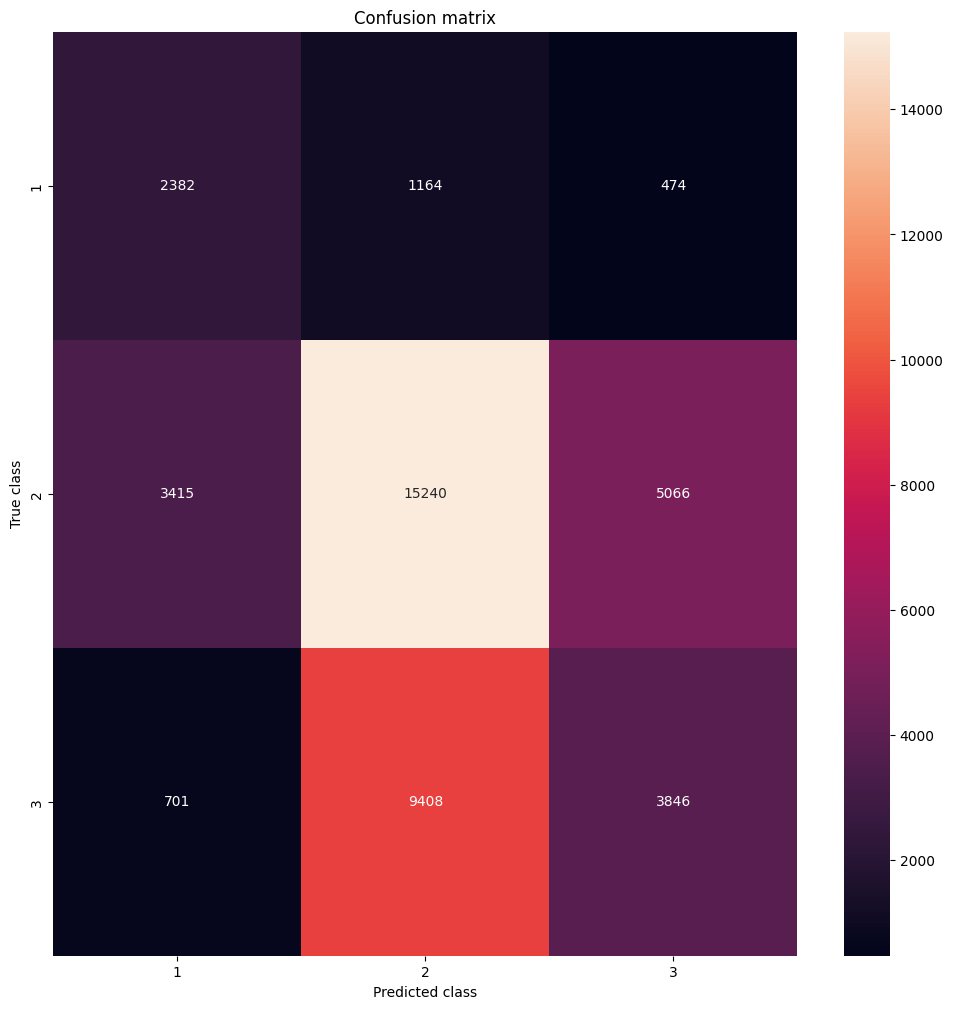

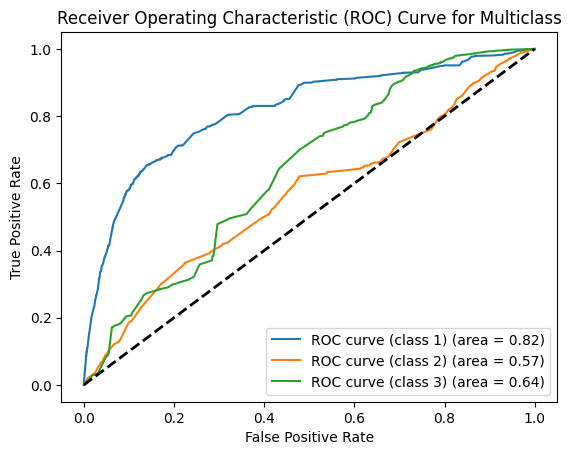

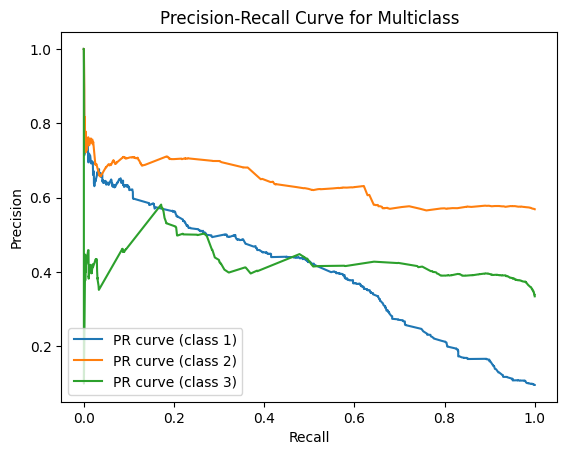

              precision    recall  f1-score   support

           1       0.37      0.59      0.45      4020
           2       0.59      0.64      0.62     23721
           3       0.41      0.28      0.33     13955

    accuracy                           0.51     41696
   macro avg       0.46      0.50      0.47     41696
weighted avg       0.51      0.51      0.50     41696



In [ ]:
model_lr, best_microF1Score_lr, best_params_lr, best_technique_lr, best_splits_lr = best_params(model=lr, params=params_lr, CV_technique="all", max_splits=15)
print("Best accuracy:",best_microF1Score_lr,", Best params:", best_params_lr,", Best technique:", best_technique_lr,", Best splits:", best_splits_lr)
pred_y = model_lr.predict(X_val)
mostrar_resultados(model_lr, X_val, y_val, pred_y)

### Lazy predict

In [ ]:
# Crea un clasificador LazyPredict
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_val, y_train, y_val)

# Muestra los modelos y sus puntajes
print(models)

 97%|█████████▋| 28/29 [25:43<03:45, 225.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 166784, number of used features: 9
[LightGBM] [Info] Start training from score -2.339185
[LightGBM] [Info] Start training from score -0.564023
[LightGBM] [Info] Start training from score -1.094585


100%|██████████| 29/29 [25:44<00:00, 53.26s/it] 

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
ExtraTreeClassifier                0.67               0.57    None      0.66   
ExtraTreesClassifier               0.67               0.57    None      0.66   
DecisionTreeClassifier             0.67               0.57    None      0.65   
BaggingClassifier                  0.67               0.56    None      0.65   
KNeighborsClassifier               0.64               0.56    None      0.63   
LGBMClassifier                     0.67               0.56    None      0.66   
RandomForestClassifier             0.67               0.56    None      0.65   
AdaBoostClassifier                 0.64               0.52    None      0.61   
NearestCentroid                    0.41               0.52    None      0.36   
QuadraticDiscriminantAnalysis      0.40               0.52    None      0.28   
GaussianNB                         0.40 

#### ExtraTreeClassifier

In [ ]:
from sklearn.tree import ExtraTreeClassifier

# Definir los parámetros a buscar
params_clf = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Crear el modelo ExtraTreeClassifier
clf = ExtraTreeClassifier(class_weight='balanced')

min: 2 max: 15 actual: 14
search: 9 - 15 actual: 14
gridSearchCV Finish
randomizeSearchCV Finish
Best accuracy: 0.5774893277726193 , Best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'} , Best technique: gridSearchCV , Best splits: 9


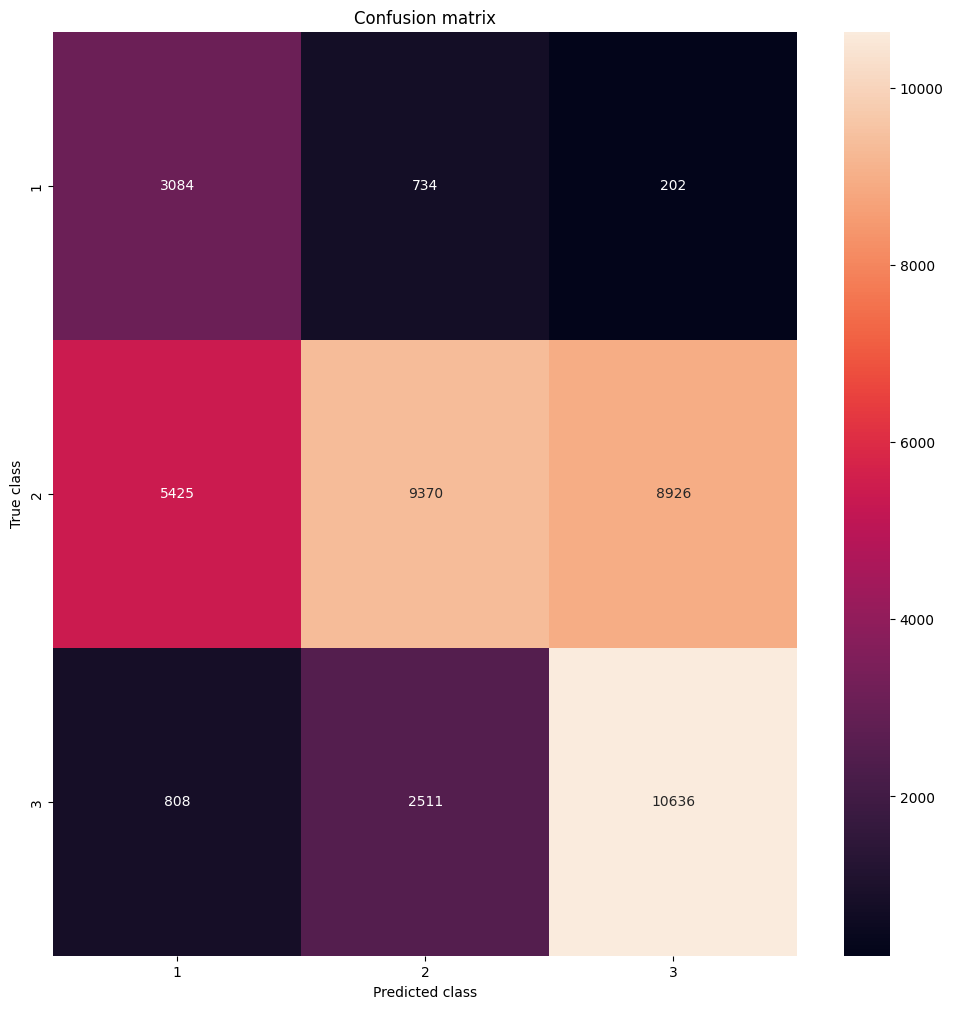

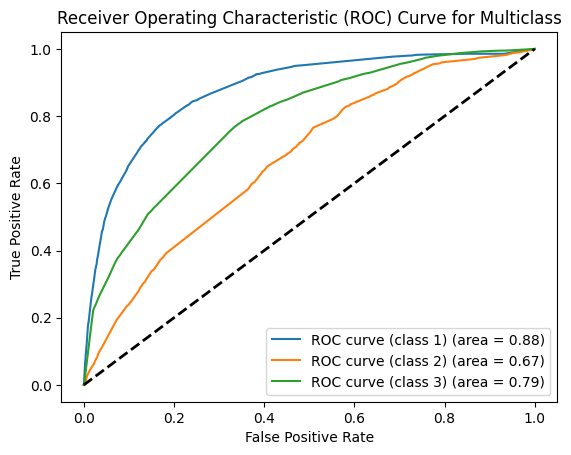

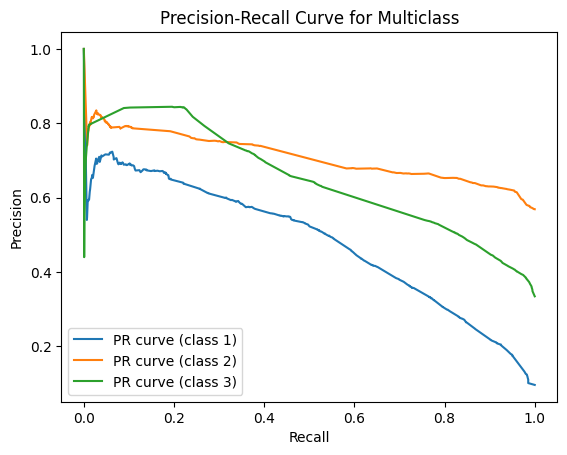

              precision    recall  f1-score   support

           1       0.33      0.77      0.46      4020
           2       0.74      0.40      0.52     23721
           3       0.54      0.76      0.63     13955

    accuracy                           0.55     41696
   macro avg       0.54      0.64      0.54     41696
weighted avg       0.63      0.55      0.55     41696



In [ ]:
model_clf, best_microF1Score_clf, best_params_clf, best_technique_clf, best_splits_clf = best_params(model=clf, params=params_clf, CV_technique="all", max_splits=15)
print("Best accuracy:",best_microF1Score_clf,", Best params:", best_params_clf,", Best technique:", best_technique_clf,", Best splits:", best_splits_clf)
pred_y = model_clf.predict(X_val)
mostrar_resultados(model_clf, X_val, y_val, pred_y)

### EXPORTAR MODELO

In [ ]:
joblib.dump(model_clf,'trained_models/earthquakeDamage_clf_modelo_entrenado.pkl')

['trained_models/earthquakeDamage_clf_modelo_entrenado.pkl']

### IMPORTAR MODELO

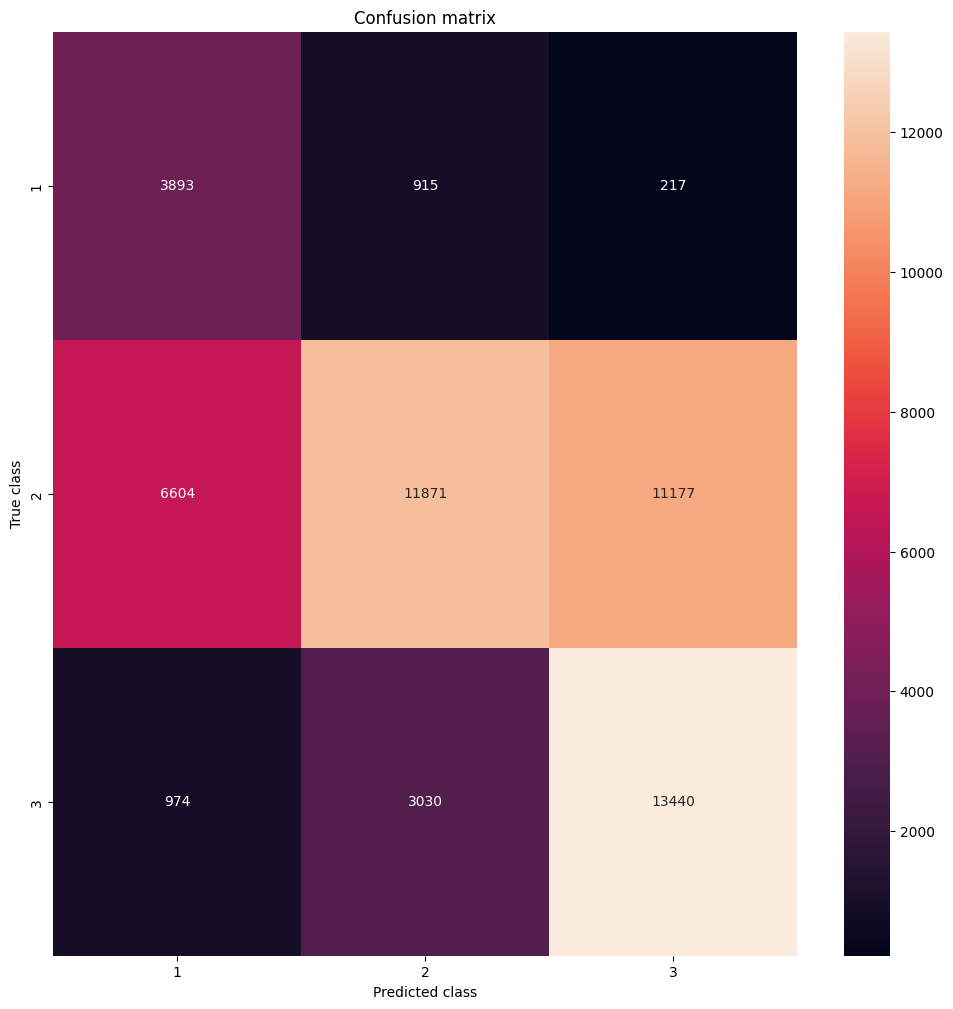

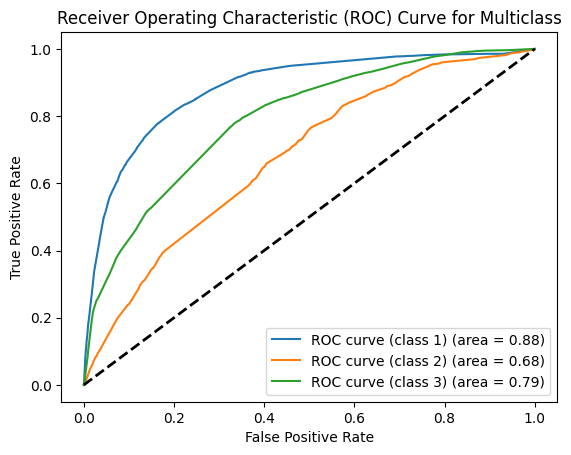

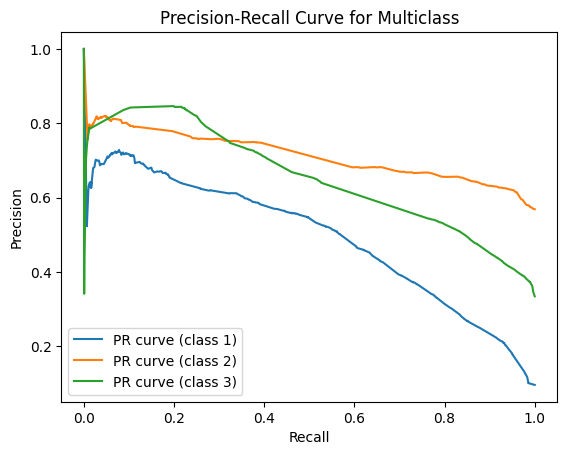

              precision    recall  f1-score   support

           1       0.34      0.77      0.47      5025
           2       0.75      0.40      0.52     29652
           3       0.54      0.77      0.64     17444

    accuracy                           0.56     52121
   macro avg       0.54      0.65      0.54     52121
weighted avg       0.64      0.56      0.56     52121



In [ ]:
extra_tree_model = joblib.load('trained_models/earthquakeDamage_clf_modelo_entrenado.pkl')

y_pred = extra_tree_model.predict(X_test)
f1_micro_clf = f1_score(y_test, y_pred, average='micro')

mostrar_resultados(extra_tree_model, X_test, y_test, y_pred)

## PREDICCION CON LOS DATOS DE LA COMPETICIÓN

In [ ]:
# Cargar el archivo CSV con los datos a predecir
data_to_predict = pd.read_csv('https://raw.githubusercontent.com/Nestorbd/Richter-s-Predictor-Modeling-Earthquake-Damage/master/datasets/test_values.csv')

In [ ]:
data_to_predict['land_surface_condition'].replace(['n', 'o', 't'],[0, 1, 2], inplace=True)
data_to_predict['foundation_type'].replace(['h', 'i', 'r', 'u', 'w'],[0, 1, 2, 3, 4], inplace=True)
data_to_predict['roof_type'].replace(['n', 'q', 'x'],[0, 1, 2], inplace=True)
data_to_predict['ground_floor_type'].replace(['f', 'm', 'v', 'x', 'z'],[0, 1, 2, 3, 4], inplace=True)
data_to_predict['other_floor_type'].replace(['j', 'q', 's', 'x'],[0, 1, 2, 3], inplace=True)
data_to_predict['position'].replace(['j', 'o', 's', 't'],[0, 1, 2, 3], inplace=True)
data_to_predict['plan_configuration'].replace(['a', 'c', 'd', 'f', 'm','n', 'o', 'q', 's','u'],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], inplace=True)
data_to_predict['legal_ownership_status'].replace(['a', 'r', 'v', 'w'],[0, 1, 2, 3], inplace=True)

In [ ]:
column_names_test = data_to_predict.columns.values

scaler_test = StandardScaler()
scaled_data_test = scaler_test.fit_transform(data_to_predict)
scaled_df_test = pd.DataFrame(scaled_data_test, columns=column_names_test)

In [ ]:
scaled_df_test = scaled_df_test[all_selected_features]

In [ ]:
# Realizar las predicciones con el modelo importado
predictions = extra_tree_model.predict(scaled_df_test)

results_rf = data_to_predict.copy()

results_rf["damage_grade"] = predictions.astype('int')

results_rf = results_rf[['building_id', 'damage_grade']]

# Guardar las columnas seleccionadas en un archivo CSV
results_rf.to_csv('results/earthquakeDamage_clf_results.csv', index=False)